<a href="https://colab.research.google.com/github/GerardvandenEynden/Advanced-QA-and-RAG-Series/blob/main/presentatie_RAG_system_(14_11_2025).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FintechAI Solutions RAG-SYSTEM
Colab-notebook: /content/drive/MyDrive/Colab Notebooks/presentatie RAG-system (14-11-2025).ipynb

![RAG_system[1].png](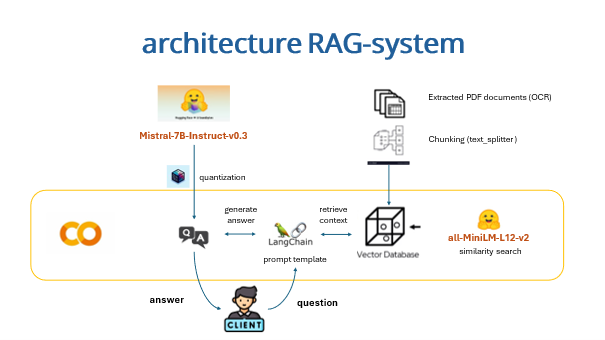)

**Keys to the model-components:**
1. The yellow perimeter in the picture above defines the Colab notebook environment in which al working components of the model are assembled (vectorstore, chatbot, agent). This is in Google cloud in this set-up but is small enough to be transferred to a PC.
2. The user-interface for the client is not designed and remains in the Colab notebook. One can experiment with interactions by entering questions in raw prompt-code. Also, no metric is applied, this is to be developed further.
3. Before the model can be used, two preparations must be completed (top half of the picture):    
- **quantization** of the Mistral Q&A model (left)
- **vectorization** of the chunked text to be questioned (right)
4. Process-flow: The LangChain pipeline from HuggingFace is used as an agent to perform a similarity search on its vectorstore. It ranks the chunks based on cosine-similarity and returns the top-3 chunks that are most simular to the question.
5. The small Mistral model (SML) answers the (vectorized) questions based on the top-3 results of the similarity search. For this a elaborate prompt is defined.


# Introduction

This is a small and simple Proof of Concept (PoC) of a Retrieval-Augmented Generation (RAG) system that can be tutored to usecases by adjusting its components and parameters. The aim is to show that the results of an on-premise and open-source model can be as good as the results from well known controlled (LLM) models like OpenAI's chatGPT for example. It functions as a simple platform to try out different solutions according to the cirumstances.

In plain terms my small language model (SML) answers questions in human language, but uses paragraphs retrieved with sentence similarity techniques to formulate the answer. This is a two-step-process: retrieve context first and answer the question second.
- For the questioning and answering I use the **Mistral-7B** model and reduce its size to only 4,2GB, so that it will fit on a PC.
- For the context retrieval and vectorization I use HuggingsFace's well known **all-miniLM**.


Improvements can be made by:
1. choosing a different model for the Q&A or vectorization tasks
2. apply relevant metrics to the output (evaluation pipeline)
3. apply different chunking techniques
4. start with a live set of documents (usecases)
5. build a user interface on a website of Power BI page
6. fine tune the Q&A model to specific tasks/ develop trainingdata
7. add extra contextual data in the vectorstore




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls /content/drive/MyDrive/Colab\ Notebooks

'ABN Amro Remediation'
 ACS
 BonsenReuling
'dotENV file.ipynb'
'EdX Databricks cursus LLM'
'financeel privé'
 FintechAISolutions
 huggingface_models
'kai-workshops Distillabs'
'kai-workshops_workshops_26032024-news-analysis_news-analysis-workshop.ipynb at main · Kickstartai-product_kai-workshops_files'
'Kopie van RAG met Mistral model (gereed) kopie van rag-tutorial.ipynb'
'presentatie notebook - kopie van rag-tutorial.ipynb'
'presentatie RAG-system.ipynb'
'presentatie RAG-system (opgeschoond).ipynb'
 Tribuut
 Untitled
'Untitled (1)'


# Notebook Setup
Is dit gedeelte nog wel nodig?

Dit deel zorgt ervoor dat de trainingdata van de github repository van Distillabs gehaald kan worden. Het deel Ollama en de rouge score lijkt me ook alleen voor hun set up geschikt.

##### Registration

The first step towards model distillation is creating an account at [prod-distil-labs](https://prod-distil-labs.auth.eu-central-1.amazoncognito.com/login?client_id=4569nvlkn8dm0iedo54nbta6fd&response_type=code&scope=email+openid&redirect_uri=https%3A%2F%2Fdocs.distillabs.ai). Once you sign up, you should be redirected to our documentation page and can use your email/password combination in the authentification section below.

### Copy over necessary data

In [3]:
%%bash
# Check if the directory exists
if [ -d "data" ]; then
  echo "Data directory does exist, nothing to do"
else
  echo "Data directory does not exist, cloning from a repository"

  # Clone the repo to a temp location
  git clone https://github.com/distil-labs/distil-labs-examples.git distil-labs-examples

  # Copy the specific subdirectory to the data directory
  cp -r distil-labs-examples/rag-tutorial/data data

  # Delete the cloned repo
  rm -rf distil-labs-examples

  echo "Subdirectory copied and repo removed."

fi

Data directory does exist, nothing to do


### Install python libraries

In [4]:
! pip install langchain-core langchain_community langchain-openai langchain-huggingface langchain-ollama
! pip install wikipedia pandas numpy requests rich pyyaml rouge_score ollama

  Using cached wikipedia-1.4.0.tar.gz (27 kB)
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=ccfc03ed6b4461b76ed0f78c610235d7711c837fe5b397d77af2f701ea939c95
  Stored in directory: /root/.cache/pip/wheels/63/47/7c/a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c8f4800a4618d390d5f252edf20e86d90b10693500d3a6cd437804a5769f6554
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built wikipedia rouge_score


In [5]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


# Step 1: Understand your data

### Retrieve a reference article
To keep things quick, we’ll use a single reference document: the English **Wikipedia** page for the Roman Empire.
In a production system you’d likely combine multiple sources, but one page is enough to demo the workflow.

In [6]:
import wikipedia, textwrap

# Disable auto-suggest so we get the exact page
page = wikipedia.page("Roman Empire", auto_suggest=False)
wikipedia_text = page.content

print("First 1200 characters of the article:\n")
print(textwrap.fill(wikipedia_text[:1200], 110))


First 1200 characters of the article:

During the classical period, the Roman Empire controlled the Mediterranean and much of Europe, Western Asia,
and North Africa. The Romans conquered most of these territories in the time of the Republic, and it was ruled
by emperors following Octavian's  assumption of power in 27 BC. Over the 4th century AD, the empire split into
western and eastern halves. The western empire collapsed in 476 AD, while the eastern empire endured until the
fall of Constantinople in 1453. By 100 BC, the city of Rome had expanded its rule from the Italian peninsula
to most of the Mediterranean and beyond. However, it was severely destabilised by civil wars and political
conflicts, which culminated in the victory of Octavian over Mark Antony and Cleopatra at the Battle of Actium
in 31 BC, and the subsequent conquest of the Ptolemaic Kingdom in Egypt. In 27 BC, the Roman Senate granted
Octavian overarching military power (imperium) and the new title of Augustus, marking

### Q&A test-set
Let’s jot down a few questions that our finished system should handle. Capturing these **early** gives us a mini test‑set for later.
These questions are also used to test Large models as a comparison. For finetuning the Q&A model an new process has to be started. The model can be trained on generated Q&A-pairs that are tutored to the task.

In [7]:
sample_qa = [
    {"question": "When did the Roman Empire collapse?", "answer": "The west Roman Empire fell in 476 CE and the Easy laster until the fall of Constantinopol in 1453."},
    {"question": "Who was the first emperor of the Roman Empire?", "answer": "Augustus (formerly Octavian)"},
    {"question": "What were the main languages spoken across the Roman Empire?", "answer": "Latin in the West and Greek in the East"},
    {"question": "What monumental arena in Rome hosted gladiatorial games?", "answer": "The Colosseum"},
]

for qa in sample_qa:
    print(f"Q: {qa['question']}\nA: {qa['answer']}\n")


Q: When did the Roman Empire collapse?
A: The west Roman Empire fell in 476 CE and the Easy laster until the fall of Constantinopol in 1453.

Q: Who was the first emperor of the Roman Empire?
A: Augustus (formerly Octavian)

Q: What were the main languages spoken across the Roman Empire?
A: Latin in the West and Greek in the East

Q: What monumental arena in Rome hosted gladiatorial games?
A: The Colosseum



# Step 2: Build vectorstore

### Index our target dataset

This section walks through loading the **Wikipedia article on the Roman Empire** into an in‑memory vector store (adapted from [https://python.langchain.com/docs/tutorials/rag/](https://python.langchain.com/docs/tutorials/rag/)):

- computer toegang geven tot geheim (HuggingFace token?)
- indexed is het vullen van de vector_store

In [8]:
from langchain_community.document_loaders import WikipediaLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

# Split the document into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
text_splits = text_splitter.split_text(wikipedia_text)
document_splits = text_splitter.create_documents(text_splits)

# Embed and index the chunks
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L12-v2")
vector_store = InMemoryVectorStore(embeddings)
indexed = vector_store.add_documents(documents=document_splits)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Step 3: set up pipeline

In [19]:
from huggingface_hub import login
login(new_session=False)

In [20]:
from transformers import pipeline, BitsAndBytesConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from langchain_community.llms import HuggingFacePipeline

## model quantization & load
The model we use for our Q&A task is the open-source Mistral-7B model which is 18GB in size and saved to MyDrive. This is reduced in size by means of quantization for which BitsAndBytes is used. The reduced size is 4,23GB. We need to specify the following:
1. model selection: mistralai/Mistral-7B-Instruct-v0.3
2. specify cahche_dir: /content/drive/MyDrive/Colab Notebooks/huggingface_models/Mistral-7B-Instruct-v0.3_8bit
3. specify quantization parameters: 8bit, nf4



**PAY AS YOU GO EUR 11,19 VOOR 100 REKENEENHEDEN**

4,23GB op MyDrive, 18GB op schijf Colab Resources, 2,6 rekeneenheden verbruikt.
foutmelding: Google Drive-opslagquotum is overschreden. Hieronder het gemeten gebruik (benut/beschikbaar):
- Systeem-RAM:     5.1 / 12.7 GB
- GPU RAM: 9.5 / 15.0 GB
- Schijf: 55.6 / 112.6 GB

Meerdere keren bitsandbytes geinstalleerd, niet duidelijk waaarom de eerste niet direct werkte.

In [12]:
!pip install bitsandbytes accelerate

In [13]:
!pip install -U bitsandbytes

In [16]:
pip install -U bitsandbytes

In [14]:
model_id = "mistralai/Mistral-7B-Instruct-v0.3"
model_save_path = "/content/drive/MyDrive/Colab Notebooks/huggingface_models/Mistral-7B-Instruct-v0.3_8bit"

In [15]:
# For 8-bit quantization:
nf4_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_4bit_quant_type="nf4", # not used for 8-bit but good practice to include
    bnb_4bit_use_double_quant=False, # not used for 8-bit
    bnb_4bit_compute_dtype=torch.bfloat16 # not used for 8-bit
)

In [10]:
# waarschijnlijk niet meer nodig....

import warnings

# Filter out the specific bitsandbytes UserWarning
warnings.filterwarnings(
    "ignore",
    message="MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization",
    category=UserWarning
)

HuggingFace Transformers Libary, causal language modelling involves textgeneration and Q&A.

- **AutoModelForCausalLM.from_pretrained()** (this is the standard way to download models)
- **model_id** (see model selected above)
- **nf4_config** (see the 8bit above)
- **torch_dtype** (error: deprecated and to replaced with 'dtype')
- **device_map** (distributes model over available devices like GPU, CPU RAM)
- **cache_dir** (path in MyDrive, persists across sessions)

In [17]:
# Load model and tokenizer separately
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=nf4_config,
    torch_dtype=torch.bfloat16,
    device_map="balanced", # Use balanced device map
    cache_dir=model_save_path # Pass cache_dir here
)

`torch_dtype` is deprecated! Use `dtype` instead!


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:798: UserWarning: Not enough free disk space to download the file. The expected file size is: 4949.45 MB. The target location /content/drive/MyDrive/Colab Notebooks/huggingface_models/Mistral-7B-Instruct-v0.3_8bit/models--mistralai--Mistral-7B-Instruct-v0.3/blobs only has 4338.27 MB free disk space.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:798: UserWarning: Not enough free disk space to download the file. The expected file size is: 4999.82 MB. The target location /content/drive/MyDrive/Colab Notebooks/huggingface_models/Mistral-7B-Instruct-v0.3_8bit/models--mistralai--Mistral-7B-Instruct-v0.3/blobs only has 4338.27 MB free disk space.
  warnings.warn(


model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## construct pipeline
A pipeline in Hugging Face is a higher-level abstraction that wraps a model and its tokenizer to perform a specific task (like "text-generation").

In [21]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, cache_dir=model_save_path)

In [23]:
# Create pipeline from loaded model and tokenizer
pipe = pipeline(
     "text-generation",
     model=model,
     tokenizer=tokenizer,
     torch_dtype=torch.bfloat16,
     device_map="auto",
     max_new_tokens=500 # Added max_new_tokens to prevent infinite generation
 )

`torch_dtype` is deprecated! Use `dtype` instead!
Device set to use cuda:0


Quick-test to verify the correct functioning of the pipeline:

In [24]:
messages = [
    {"role": "user", "content": "Who are you?"},
]
response = pipe(messages)
print(response)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'generated_text': [{'role': 'user', 'content': 'Who are you?'}, {'role': 'assistant', 'content': ' I am a model of an artificial intelligence designed to assist with a variety of tasks. I\'m here to help answer questions, provide information, and engage in friendly conversation. I don\'t have personal experiences or emotions, but I\'m programmed to understand and respond to human input as best I can. How can I assist you today?\n\n[For more information about me, check out my "About Me" section!]'}]}]


In [25]:
from langchain_core.documents import Document
# from langchain_openai import ChatOpenAI # We will no longer use this for the HF pipeline
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.language_models.llms import LLM # Import base LLM class


class RAG:
    def __init__(self, vector_store: InMemoryVectorStore, llm: LLM): # Change type hint to base LLM
        self.vector_store = vector_store
        self.llm = llm

        self.SYSTEM_PROMPT = """
You are a problem solving model working on task_description XML block:

<task_description>
Answer the question using information from one of the context paragrpahs.
The answer should should contain all important information from the context paragraph but stay short, one sentence maximum.
</task_description>
"""

        self.PROMPT_TEMPLATE = """
{system_prompt}

Now for the real task, solve the task in question block based on the context in context block.
Generate only the solution, do not generate anything else.

<context>
{context}
</context>

<question>
{question}
</question>
"""

    def retrieve(self, question: str, k: int = 5):
        return self.vector_store.similarity_search(question, k=k)

    def generate(self, question: str, context_docs):
        context = "\n\n".join(doc.page_content for doc in context_docs)
        # Combine system prompt, context, and question into a single string
        prompt = self.PROMPT_TEMPLATE.format(
            system_prompt=self.SYSTEM_PROMPT,
            context=context,
            question=question
        )
        # Call the LLM with a single string input
        # The method name might vary depending on the specific LLM class,
        # but 'invoke' is common in LangChain
        response = self.llm.invoke(prompt)
        # Extract and return only the generated text from the response
        return response.strip()

    def answer(self, question: str):
        return self.generate(question, self.retrieve(question))

#Step 4:  Test the RAG-SYSTEM

De RAG class geeft nu naast het antwoord ook de prompts en de context weer. Op zich leuk om die te kunnen controleren maar dit hoort niet.

CONCISE ANSWERS

the solution you provided with the strip method did not work. Also, when I ask an open question, the model geberates subsequent questions with answers on those. This is nice because this gives more information which I want with complex questions. It does not formulate or generate a concise and precise answer from all of this it seems.

- hoe maak je van de output een begrijpelijk en compact antwoord? Komt het door het model of door de pipeline dat dit er van de output geen geheel wordt gemaakt?
- de antwoorden zijn correct en het model stelt aanvulende vragen waarvan de antwoorden relevant zijn.

In [26]:
hf_llm = HuggingFacePipeline(pipeline=pipe)

/tmp/ipython-input-1616488958.py:1: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFacePipeline``.
  hf_llm = HuggingFacePipeline(pipeline=pipe)


In [27]:
tuned_rag = RAG(vector_store=vector_store, llm=hf_llm)
print(tuned_rag.answer("When did the roman empire collapse?"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


You are a problem solving model working on task_description XML block:

<task_description>
Answer the question using information from one of the context paragrpahs.
The answer should should contain all important information from the context paragraph but stay short, one sentence maximum.
</task_description>


Now for the real task, solve the task in question block based on the context in context block.
Generate only the solution, do not generate anything else.

<context>
=== Fall in the West and survival in the East ===
The Western Roman Empire began to disintegrate in the early 5th century. The Romans fought off all invaders, most famously Attila, but the empire had assimilated so many Germanic peoples of dubious loyalty to Rome that the empire started to dismember itself. Most chronologies place the end of the Western Roman Empire in 476, when Romulus Augustulus was forced to abdicate to the Germanic warlord Odoacer.

During the classical period, the Roman Empire controlled the Medit

CONTEXT

The Roman Empire ruled the Mediterranean and much of Europe, Western Asia and North Africa. The Romans conquered most of this during the Republic, and it was ruled by emperors following Octavian's  assumption of effective sole rule in 27 BC. The western empire collapsed in 476 AD, but the eastern empire lasted until the fall of Constantinople in 1453.

=== Fall in the West and survival in the East ===
The Western Roman Empire began to disintegrate in the early 5th century. The Romans fought off all invaders, most famously Attila, but the empire had assimilated so many Germanic peoples of dubious loyalty to Rome that the empire started to dismember itself. Most chronologies place the end of the Western Roman Empire in 476, when Romulus Augustulus was forced to abdicate to the Germanic warlord Odoacer.

The Roman Empire was one of the largest in history, with contiguous territories throughout Europe, North Africa, and the Middle East. The Latin phrase imperium sine fine ("empire without end") expressed the ideology that neither time nor space limited the Empire. In Virgil's Aeneid, limitless empire is said to be granted to the Romans by Jupiter. This claim of universal dominion was renewed when the Empire came under Christian rule in the 4th century. In addition to annexing large regions, the Romans directly altered their geography, for example cutting down entire forests.

/CONTEXT


ANSWER

=== Fall in the West and survival in the East ===

The Western Roman Empire began to disintegrate in the early 5th century. The Romans fought off all invaders, most famously Attila, but the empire had assimilated so many Germanic peoples of dubious loyalty to Rome that the empire started to dismember itself. Most chronologies place the end of the Western Roman Empire in 476, when Romulus Augustulus was forced to abdicate to the Germanic

## tweaking parameters

Parameters to be adjusted:
- number of tokens = 500
- number of retrieved paragraphs top-K = 3

In [28]:
sample_qa = [
    {"question": "When did the Roman Empire collapse?", "answer": "The west Roman Empire fell in 476 CE and the Easy laster until the fall of Constantinopol in 1453."},
    {"question": "Who was the first emperor of the Roman Empire?", "answer": "Augustus (formerly Octavian)"},
    {"question": "What were the main languages spoken across the Roman Empire?", "answer": "Latin in the West and Greek in the East"},
    {"question": "What monumental arena in Rome hosted gladiatorial games?", "answer": "The Colosseum"},
]

for qa in sample_qa:
    print(f"Q: {qa['question']}\nA: {qa['answer']}\nP: {tuned_rag.answer(qa['question'])}\n")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Q: When did the Roman Empire collapse?
A: The west Roman Empire fell in 476 CE and the Easy laster until the fall of Constantinopol in 1453.
P: You are a problem solving model working on task_description XML block:

<task_description>
Answer the question using information from one of the context paragrpahs.
The answer should should contain all important information from the context paragraph but stay short, one sentence maximum.
</task_description>


Now for the real task, solve the task in question block based on the context in context block.
Generate only the solution, do not generate anything else.

<context>
=== Fall in the West and survival in the East ===
The Western Roman Empire began to disintegrate in the early 5th century. The Romans fought off all invaders, most famously Attila, but the empire had assimilated so many Germanic peoples of dubious loyalty to Rome that the empire started to dismember itself. Most chronologies place the end of the Western Roman Empire in 476, whe

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Q: Who was the first emperor of the Roman Empire?
A: Augustus (formerly Octavian)
P: You are a problem solving model working on task_description XML block:

<task_description>
Answer the question using information from one of the context paragrpahs.
The answer should should contain all important information from the context paragraph but stay short, one sentence maximum.
</task_description>


Now for the real task, solve the task in question block based on the context in context block.
Generate only the solution, do not generate anything else.

<context>
the first epoch of Roman imperial history. Although the republic stood in name, Augustus had all meaningful authority. During his 40-year rule, a new constitutional order emerged so that, upon his death, Tiberius would succeed him as the new de facto monarch.

Several states claimed to be the Roman Empire's successor. The Holy Roman Empire was established in 800 when Pope Leo III crowned Charlemagne as Roman emperor. The Russian Tsardo

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Q: What were the main languages spoken across the Roman Empire?
A: Latin in the West and Greek in the East
P: You are a problem solving model working on task_description XML block:

<task_description>
Answer the question using information from one of the context paragrpahs.
The answer should should contain all important information from the context paragraph but stay short, one sentence maximum.
</task_description>


Now for the real task, solve the task in question block based on the context in context block.
Generate only the solution, do not generate anything else.

<context>
== Languages ==

Latin and Greek were the main languages of the Empire, but the Empire was deliberately multilingual. Andrew Wallace-Hadrill says "The main desire of the Roman government was to make itself understood". At the start of the Empire, knowledge of Greek was useful to pass as educated nobility and knowledge of Latin was useful for a career in the military, government, or law. Bilingual inscriptions i

- Q: Who was the first emperor of the Roman Empire?
- A: Augustus (formerly Octavian)
- P: Augustus was the first de facto emperor of the Roman Empire.


- Q: When did the Roman Empire collapse?
- A: The west Roman Empire fell in 476 CE and the Easy laster until the fall of Constantinopol in 1453.
- P: The Roman Empire collapsed in 476 AD


- Q: What were the main languages spoken across the Roman Empire?
- A: Latin in the West and Greek in the East
- P: The main languages spoken across the Roman Empire were Latin and Greek.

Was there a legal requirement for Latin in the Empire?
There was never a legal requirement for Latin in the Empire.
How did the Roman government promote Latin usage?
The Roman government promoted Latin usage to project power and a higher social class.
What other languages continued to be spoken within the Empire despite the dominance of Latin and Greek?
Coptic was commonly used in Egypt, and local languages such as Punic, Gaulish, and Aramaic continued to be used in various regions, including Africa and Syria.


- Q: What monumental arena in Rome hosted gladiatorial games?
- A: The Colosseum
- P: The Flavian Amphitheatre, known as the Colosseum

In [ ]:
print(tuned_rag.answer("Who was the last emperor of the roman empire?"))

OPEN VRAAG met tokens set to 500 (k-3 sentence_similarity):

What was the legal status of women in the roman empire?
- Roman women retained ownership of any property they brought into the marriage, were legally emancipated when their father died, and had some degree of independence compared to many other cultures up to the modern period.


What were the rights of freed slaves in Rome?
- Freed slaves in Rome enjoyed active political freedom, including the right to vote. They continued to have customary and legal obligations to their former master, but could not hold public office or the highest state priesthoods, marry a woman from a senatorial family, or achieve legitimate senatorial rank themselves. However, they could play a priestly role and held key positions in the government bureaucracy.


What was the citizenship status of freeborn Roman women?
- Free

OPEN VRAAG met tokens set to 500 (k-3 sentence_similarity):

What was the legal status of women in the roman empire?

- Roman women were citizens with the power to own property, enter contracts, and engage in business, but they did not have the right to vote or hold political office.

What was the impact of the archaic manus marriage on the degree of independence Roman women enjoyed compared to many other cultures up to the modern period?

- The archaic manus marriage, while technically keeping women under their father's legal authority, allowed them to retain ownership of any property they brought into the marriage, and become legally emancipated upon their father's death, thus providing a degree of independence compared to many other cultures up to the modern period.

What rights did Roman women have in terms of inheritance?

- Roman women had equal inheritance rights with men

OPEN VRAAG met tokens set to 500 (k-5 sentence_similarity):


What was the legal status of women in the roman empire?

- Freeborn Roman women were citizens but did not vote, hold political office, or serve in the military.

What was the legal status of a married woman in the Roman Empire?

- A married woman retained ownership of any property she brought into the marriage and became legally emancipated when her father died.

What was the legal status of a freed slave in the Roman Empire?

- A freed slave enjoyed active political freedom, including the right to vote, but could not hold public office or the highest state priesthoods.

What was the legal status of a non-Romann in the Roman Empire?

- Non-Romans were referred to as peregrini, and had limited legal rights compared to citizens.

What was the legal distinction between free and enslaved people in the Roman Empire?

- All humans were either free (liberi) or slaves (servi). The legal status of free people was further defined by their citizenship.

What was the legal distinction between citizens and non-citizens in the Roman Empire?

- Most citizens held limited rights, but were entitled to legal protections and privileges not enjoyed by non-citizens. Free people not considered citizens, but living within the Roman world, were peregrini, non-Romans.

What was the legal status of a one-man woman in the Roman Empire?

- A "one-man woman" (univira) who had married only once had little stigma attached to divorce or remarriage after being widowed or divorced.

What was the legal status of a mother in the Roman Empire regarding her children's citizenship?

- A mother's citizen status determined that of her children,

In [ ]:
print(tuned_rag.answer("What was the legal status of women in the roman empire?"))